In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters
from datetime import date, timedelta
import warnings

warnings.filterwarnings("ignore")

Using TensorFlow backend


C:\Users\Abishek\AppData\Local\Temp\ipykernel_9092\1111653661.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


# Step 1

### a. Gather information on the time series of closes. Provide a characterization of the main properties of that time-series.

#### Downloading data

In [2]:
end_date = date.today()
start_date = end_date - timedelta(days=2500)

df = pd.DataFrame(yf.download("AMZN", start=start_date, end=end_date)["Adj Close"])
df.columns = ["close"]

print(df.shape)
print(df.tail(5))

[*********************100%%**********************]  1 of 1 completed
(1725, 1)
                 close
Date                  
2023-11-16  142.830002
2023-11-17  145.179993
2023-11-20  146.130005
2023-11-21  143.899994
2023-11-22  146.710007


#### Summary statistics

In [3]:
print(df["close"].describe())

count    1725.000000
mean      109.687604
std        39.625282
min        40.374001
25%        83.727997
50%        99.493500
75%       148.878494
max       186.570496
Name: close, dtype: float64


#### Distribution

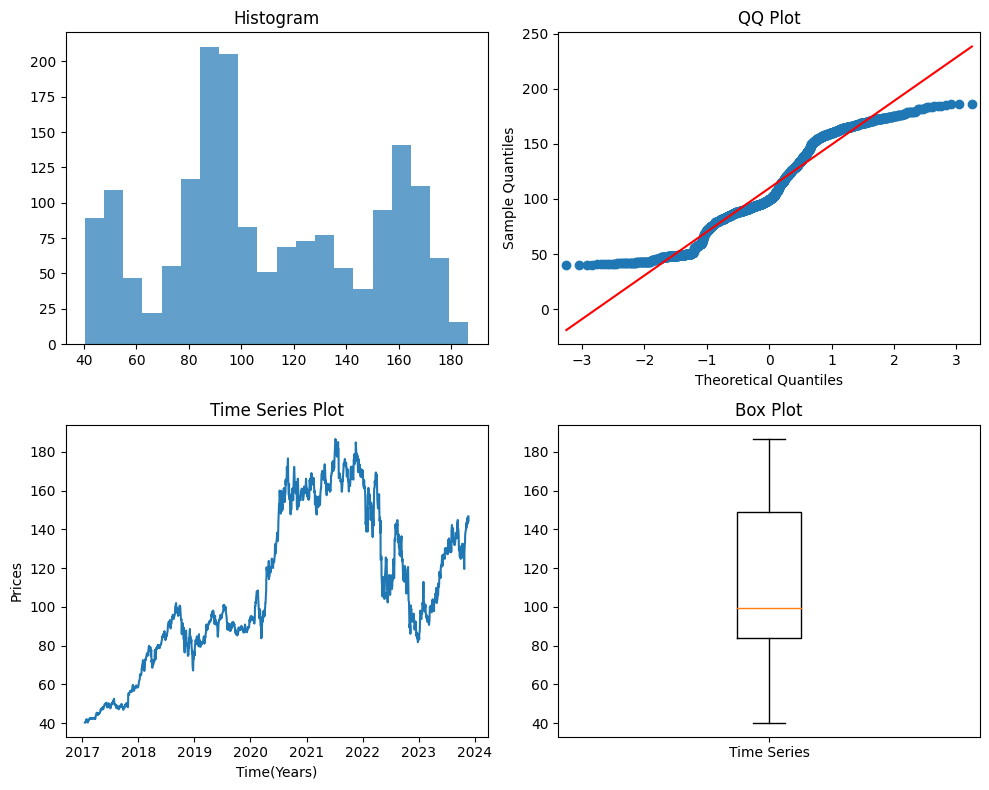

In [4]:
def plot_distribution(time_series_df):
    """
    Plot a 2x2 grid with histogram, QQ plot, time series plot, and box plot.

    Parameters:
    - time_series_df: DataFrame with a column containing time series data.
    """
    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Plotting Histogram
    axs[0, 0].hist(time_series_df, bins=20, alpha=0.7)
    axs[0, 0].set_title('Histogram')

    # QQ Plot
    sm.qqplot(time_series_df, line='s', ax=axs[0, 1])
    axs[0, 1].set_title('QQ Plot')

    # Time Series Plot
    axs[1, 0].plot(time_series_df)
    axs[1, 0].set_title('Time Series Plot')
    axs[1, 0].set_xlabel('Time(Years)')
    axs[1, 0].set_ylabel('Prices')

    # Box Plot
    axs[1, 1].boxplot(time_series_df)
    axs[1, 1].set_title('Box Plot')
    axs[1, 1].set_xticklabels(['Time Series'])

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    plt.show()
    
plot_distribution(df["close"])

#### Persistance

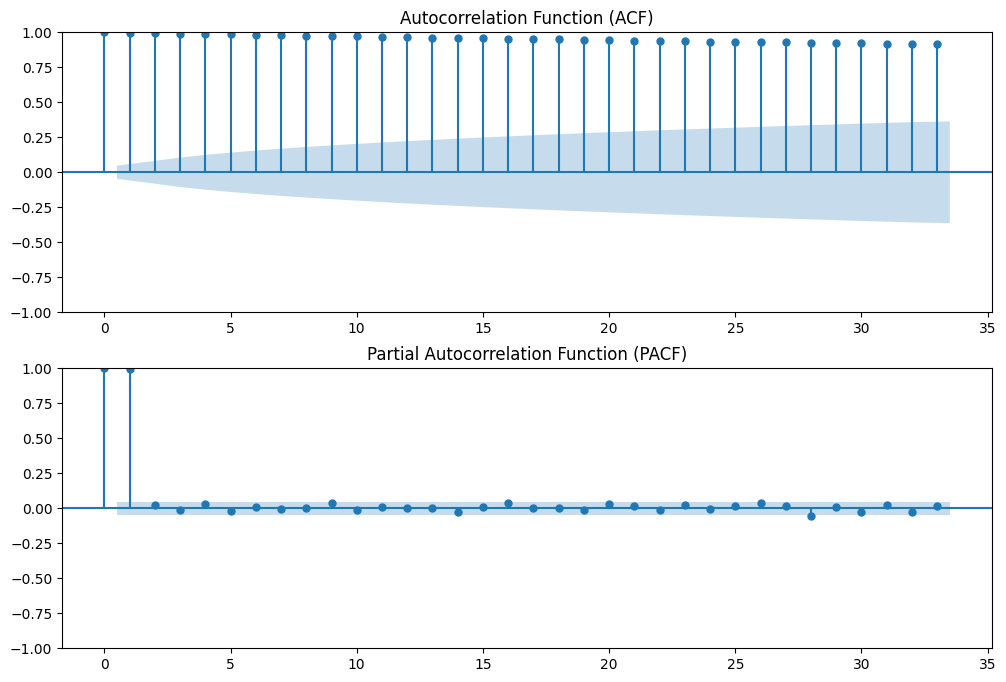

In [5]:
def plot_acf_pacf(time_series, lags=None):
    """
    Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) of a time series.

    Parameters:
    - time_series: The time series data.
    - lags: The number of lags to include in the plot. Default is None (plots all lags).
    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot ACF
    plot_acf(time_series, lags=lags, ax=ax1)
    ax1.set_title('Autocorrelation Function (ACF)')

    # Plot PACF
    plot_pacf(time_series, lags=lags, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function (PACF)')

    plt.show()
    
plot_acf_pacf(df["close"])

#### Stationarity

In [6]:
def stationarity_tests(time_series):
    """
    Perform stationarity tests using ADF and KPSS tests.

    Parameters:
    - time_series: The time series data.

    Returns:
    - None (Prints the results of the tests).
    """
    # ADF test
    result_adf = adfuller(time_series)
    print("ADF Test:")
    print("ADF Statistic:", result_adf[0])
    print("p-value:", result_adf[1])
    print("Critical Values:", result_adf[4])
    print("Is the time series stationary (ADF)?", "No" if result_adf[1] > 0.05 else "Yes")
    print("\n" + "-"*40 + "\n")

    # KPSS test
    result_kpss = kpss(time_series, regression='c', nlags="auto")
    print("KPSS Test:")
    print("KPSS Statistic:", result_kpss[0])
    print("p-value:", result_kpss[1])
    print("Critical Values:", result_kpss[3])
    print("Is the time series stationary (KPSS)?", "Yes" if result_kpss[1] > 0.05 else "No")
    
stationarity_tests(df["close"])

ADF Test:
ADF Statistic: -1.7351776192480834
p-value: 0.41308507714327525
Critical Values: {'1%': -3.4341487606638452, '5%': -2.863217940480328, '10%': -2.5676632884862807}
Is the time series stationary (ADF)? No

----------------------------------------

KPSS Test:
KPSS Statistic: 3.862656853895743
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is the time series stationary (KPSS)? No


### b. Perform the same analysis for a transformed version of the time series that is stationary.

#### Percentage change

In [7]:
df["returns"] = df["close"].pct_change()
df.dropna(inplace=True)

print(df.shape)
print(df.tail())

(1724, 2)
                 close   returns
Date                            
2023-11-16  142.830002 -0.002584
2023-11-17  145.179993  0.016453
2023-11-20  146.130005  0.006544
2023-11-21  143.899994 -0.015260
2023-11-22  146.710007  0.019528


#### Summary statistics

In [8]:
print(df["returns"].describe())

count    1724.000000
mean        0.000977
std         0.021379
min        -0.140494
25%        -0.009020
50%         0.001305
75%         0.011649
max         0.135359
Name: returns, dtype: float64


#### Distribution

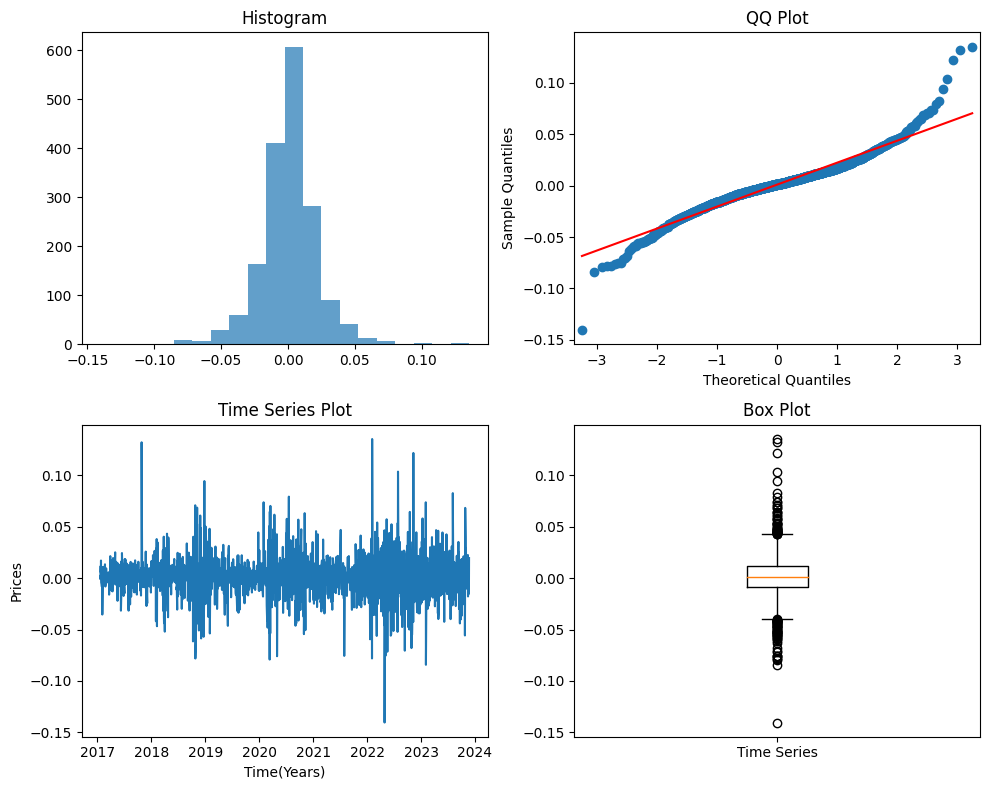

In [9]:
plot_distribution(df["returns"])

#### Persistance

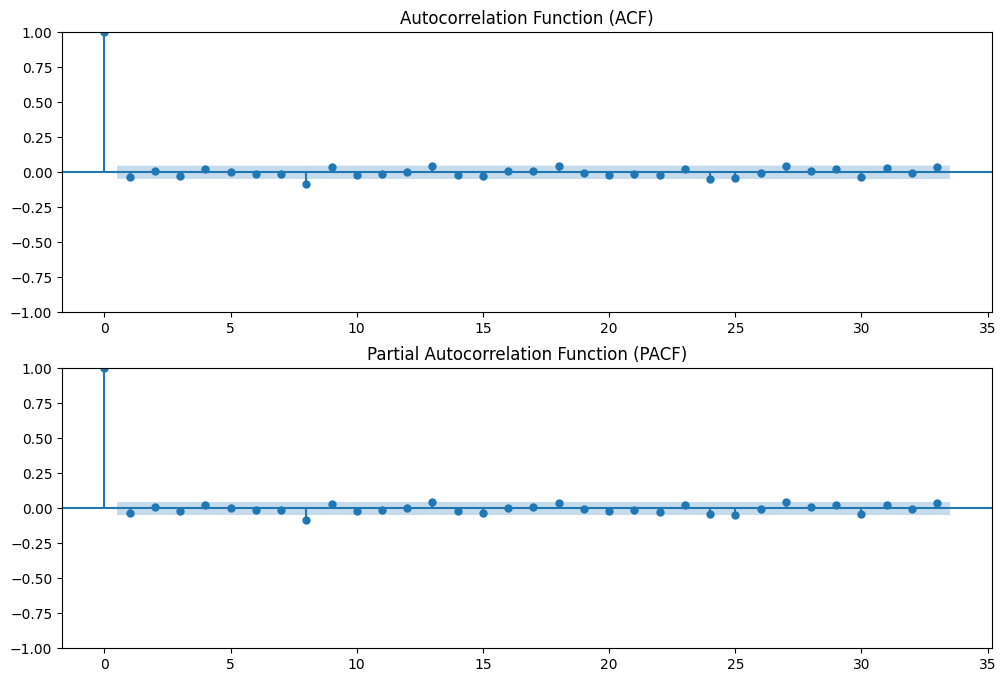

In [10]:
plot_acf_pacf(df["returns"])

In [11]:
stationarity_tests(df["returns"])

ADF Test:
ADF Statistic: -42.826227936214565
p-value: 0.0
Critical Values: {'1%': -3.434150968697906, '5%': -2.8632189151648864, '10%': -2.567663807484617}
Is the time series stationary (ADF)? Yes

----------------------------------------

KPSS Test:
KPSS Statistic: 0.16850048289181457
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is the time series stationary (KPSS)? Yes


### c. Use fractional differencing to obtain a new version of the time series that is stationary, but retains relevant information about the data.

In [12]:
def get_weights(d, lags):
    w = [1]
    for k in range(1, lags):
        w.append(-w[-1] * ((d - k + 1)) / k)
    w = np.array(w).reshape(-1, 1)
    return w

def cutoff_find(order, cutoff, start_lags):
    val = np.inf
    lags = start_lags
    while abs(val) > cutoff:
        w = get_weights(order, lags)
        val = w[len(w) - 1]
        lags += 1
    return lags

def ts_differencing_tau(series, order, tau):
    lag_cutoff = cutoff_find(order, tau, 1)
    weights = get_weights(order, lag_cutoff)
    res = 0
    for k in range(lag_cutoff):
        res += weights[k] * series.shift(k).fillna(0)
    return res[lag_cutoff:]

def find_first_lte(lst, b):
    for index, element in enumerate(lst):
        if element <= b:
            return index
    return None

def find_optimal_differencing_order(df, possible_d, tau, sig=0.01):
    adf_stat_holder = [None] * len(possible_d)

    for i in range(len(possible_d)):
        adf_stat_holder[i] = adfuller(ts_differencing_tau(df["close"], possible_d[i], tau))[1]

    plt.plot(possible_d, adf_stat_holder)
    plt.title("ADF p-value by differencing order (original series)")
    plt.axhline(y=sig, color="r")
    fig = plt.gcf()
    fig.set_size_inches(7, 4)
    plt.show()

    diff = possible_d[find_first_lte(adf_stat_holder, sig)]
    return diff

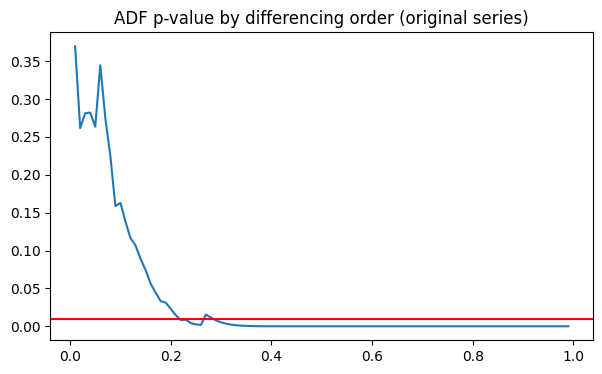

0.22


In [13]:
optimal_d = find_optimal_differencing_order(df, np.divide(range(1, 100), 100), 1e-4)
print(optimal_d)

In [14]:
df["close_fd"] = ts_differencing_tau(df["close"], optimal_d, 1e-4)
df.dropna(inplace=True)
print(df.shape)
print(df.tail())

(1244, 3)
                 close   returns   close_fd
Date                                       
2023-11-16  142.830002 -0.002584  35.690571
2023-11-17  145.179993  0.016453  38.030555
2023-11-20  146.130005  0.006544  38.380109
2023-11-21  143.899994 -0.015260  35.644298
2023-11-22  146.710007  0.019528  38.649163


#### Summary

In [15]:
print(df["close_fd"].describe())

count    1244.000000
mean       28.502477
std        10.534249
min         2.283109
25%        19.889698
50%        28.622342
75%        37.053621
max        53.902299
Name: close_fd, dtype: float64


#### Distribution

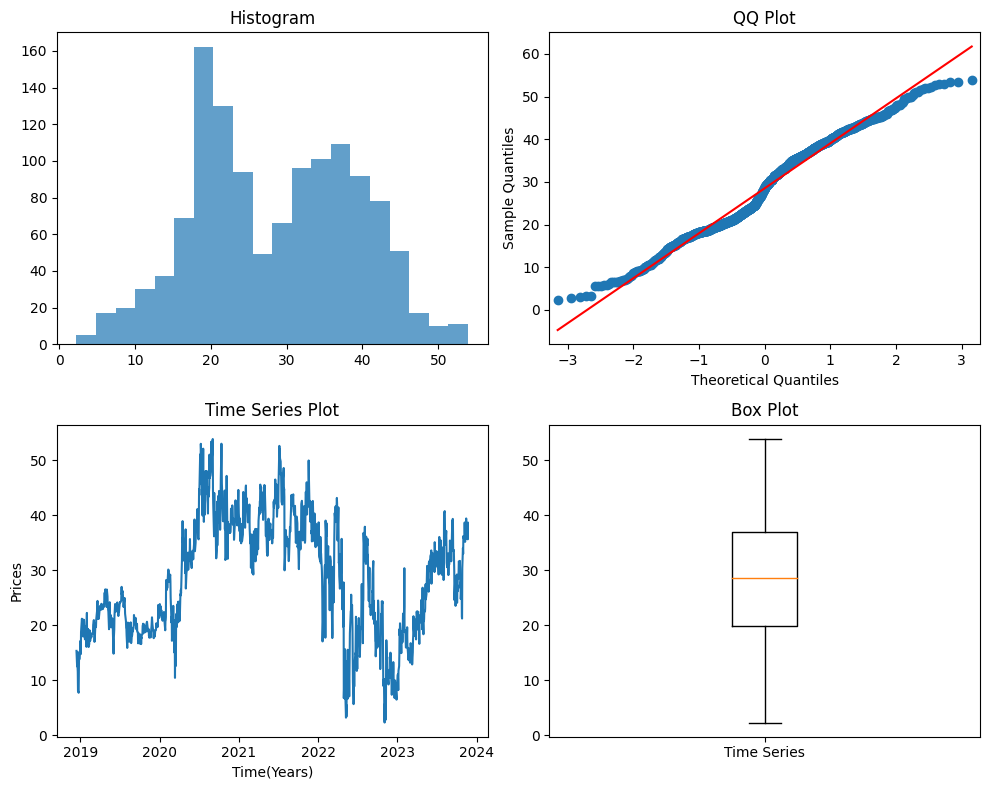

In [16]:
plot_distribution(df["close_fd"])

#### Persistence

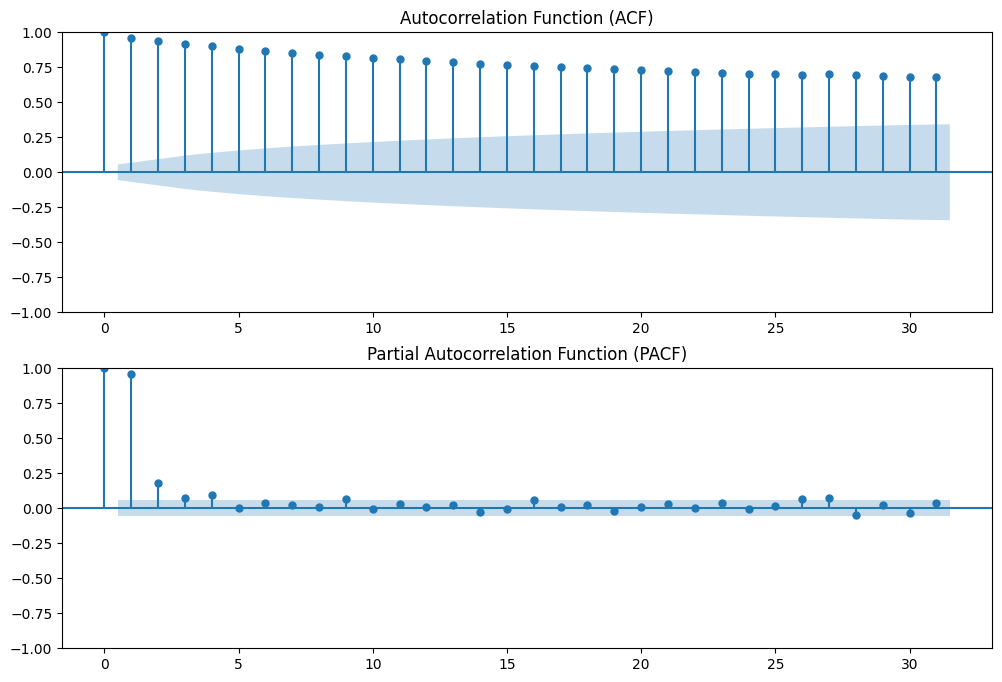

In [17]:
plot_acf_pacf(df["close_fd"])

#### Stationarity

In [18]:
stationarity_tests(df["close_fd"])

ADF Test:
ADF Statistic: -3.4945698892981656
p-value: 0.008127650868406831
Critical Values: {'1%': -3.435634587707382, '5%': -2.8638736617392837, '10%': -2.568012472034339}
Is the time series stationary (ADF)? Yes

----------------------------------------

KPSS Test:
KPSS Statistic: 0.8170570773751781
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is the time series stationary (KPSS)? No


### d. Summary about the data

We decided to select Amazon (AMZN) as our security of interest, given its progression as a financial instrument in the last few years. The following data represent the summary statistics of the price level in the period under consideration. As we can see there is a lot of variation (\\$39.65), with the price fluctuating in a wide range from a minimum of \\$40.37 to a maximum of \\$186.57.
Considering the histogram, it seams to have 3 peaks hence it doesn’t fit the definition of a normal distribution. The QQ plot also supports this claim since its curve shows us it is multi-peaked. The time series also displays the rising of Amazon’s closing prices during the periods 2017 to late 2021 and gradual fall before 2023 and its rise again during 2023. 

We can see that the p-value obtained from the test is less than 0.05 so we are going to reject the null hypothesis “Time series is stationary”, that means the time series is non-stationary.  This means the historical close prices of Amazon may exhibit trends or patterns, and it might be challenging to make predictions based on historical data alone. The KPSS test also suggests that the series is not stationary. This indicates stronger evidence regarding the non-stationarity of the data.

After calculating the percentage returns on the close prices, the histogram showed one peak and the QQ plot also aligns with the normal line hence it looks approximately normal. The time series also shows most of the values are around 0. 
The ADF and KPSS test of the returns shows a very low test statistic value which implies a high level of confidence in considering the time series as stationary. This stationarity allows for better predictability based on historical data and can enhance the reliability of financial models and forecasts. However, form the ACF and PACF plots, we can see that there is no persistence in the data.

After fractional differencing, the distribution seemed to have 2 peaks, but the QQ plot is close to that of a normal distribution. Also, there is significant variation (\\$10.53) in the fractional differencing of the close prices considering the maximum being \\$53.9 and the minimum being \\$2.28. However, the mean is \\$28.49 and the median is \\$28.55 which are close. 
That withstanding, the ADF test indicates that there is stationarity in the differenced prices. In fractionally differenced time series, the ACF and PACF plots suggests the auto-corrlation exists, which can be captured by the model.

# Step 2

### a. Using past information of the time series as inputs, build and train an MLP that is designed to predict the level of the time series.

In [19]:
class TimeSeriesModel:
    def __init__(self, data, lags, random_state=None):
        """
        Initializes the TimeSeriesModel.

        :param data: pd.Series, the time series data
        :param lags: list, the specific lags to include
        :param random_state: int or None, seed for random state
        """
        self.data = data
        self.lags = lags
        self.features = None
        self.target = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.random_state = random_state
        self.best_model = None

    def create_lagged_dataset(self):
        """
        Creates a dataset with specific lagged observations.
        """
        df = pd.DataFrame(self.data)
        for lag in self.lags:
            df[f'lag_{lag}'] = self.data.shift(lag)
        df.dropna(inplace=True)
        self.features = df.drop(self.data.name, axis=1)
        self.target = df[self.data.name]

    def split_data(self, test_size=0.2, shuffle=False):
        """
        Splits the data into training and testing sets.

        :param test_size: float, the proportion of the dataset to include in the test split
        :param shuffle: bool, whether to shuffle the data before splitting
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.features, self.target, test_size=test_size, shuffle=shuffle, random_state=self.random_state
        )

    def standardize_data(self):
        """
        Standardizes the data using StandardScaler.
        """
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)

    def hyperparameter_tuning(self, directory, project_name, max_epochs=30, factor=3, validation_split=0.2):
        """
        Perform hyperparameter tuning using Keras Tuner.

        :param max_epochs: int, the maximum number of epochs per trial
        :param factor: int, reduction factor for the number of trials
        :param directory: str, directory to store tuning results
        :param project_name: str, project name for tuning
        :param validation_split: float, the proportion of training data to use as validation data during tuning
        """
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train, self.y_train, test_size=validation_split, random_state=self.random_state
        )

        tuner = Hyperband(
            self.build_model,
            objective='val_loss',
            max_epochs=max_epochs,
            factor=factor,
            directory=directory,
            project_name=project_name
        )

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        tuner.search(self.X_train, self.y_train, validation_data=(self.X_val, self.y_val), epochs=max_epochs,
                     batch_size=32, callbacks=[early_stopping], verbose=0)

        self.best_model = tuner.get_best_models(num_models=1)[0]
        best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

        self.best_model.summary()

        self.best_model.fit(self.X_train, self.y_train, epochs=100, batch_size=32,
                            validation_data=(self.X_val, self.y_val), callbacks=[early_stopping], verbose=0)

    def build_model(self, hp):
        """
        Build the model for hyperparameter tuning.

        :param hp: HyperParameters object
        :return: Keras model
        """
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                        input_dim=len(self.lags), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1))) 
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1))) 
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                      loss='mean_squared_error')

        return model

    def plot_loss(self, history):
        """
        Plots the training and validation loss over epochs.

        :param history: Training history from Keras model training
        """
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(12, 6))
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

Reloading Tuner from MLP\MLP_close\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               20640     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 161       
                                                                 
Total params: 21,441
Trainable params: 21,441
Non-trainable params: 0
_________________________________________________________________
Epoch

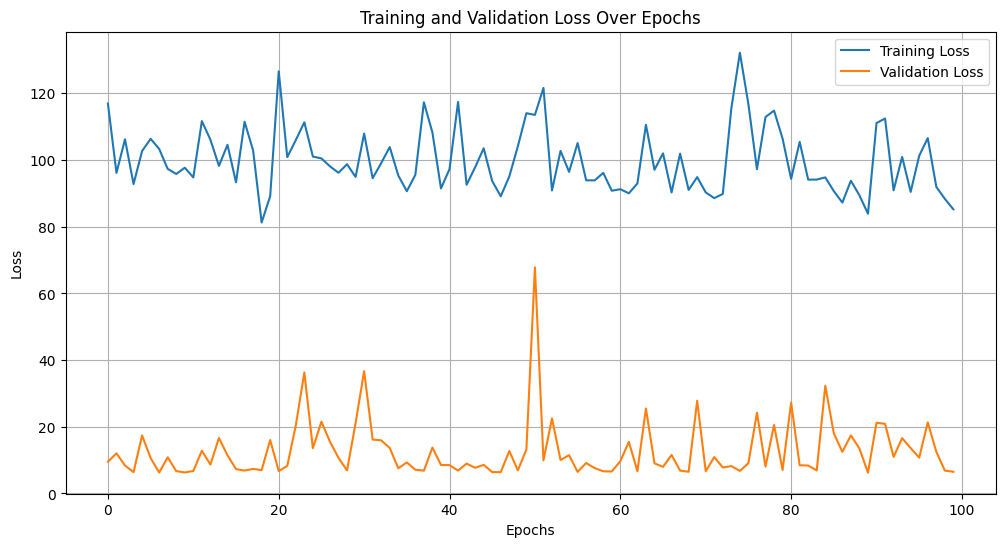

8/8 [==============================] - 0s 429us/step


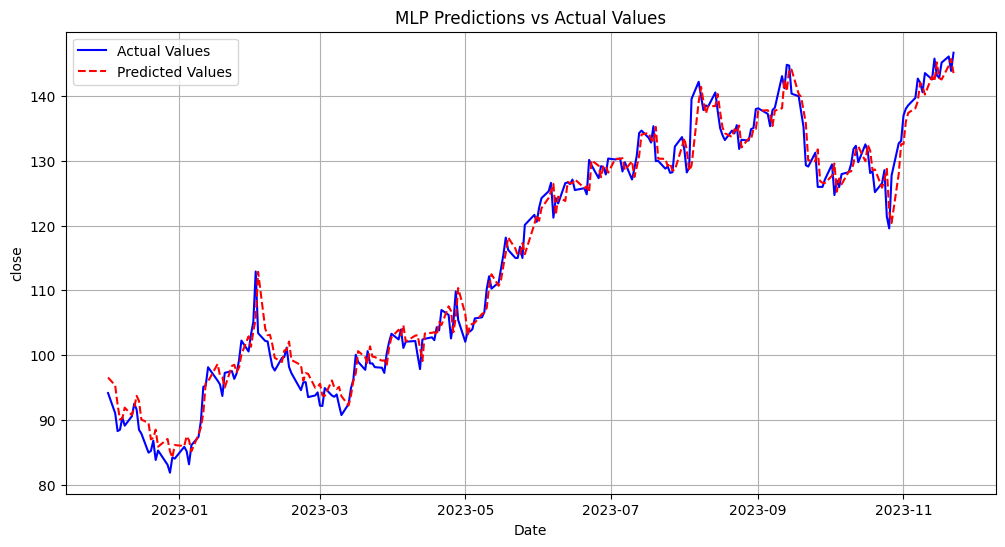

In [20]:
specific_lags = [1, 5, 10, 20]

mlp_close = TimeSeriesModel(df["close"], specific_lags, random_state=42)
mlp_close.create_lagged_dataset()
mlp_close.split_data()
mlp_close.standardize_data()

# Performing hyperparameter tuning
mlp_close.hyperparameter_tuning(directory="MLP", project_name="MLP_close")

# Training the model with the best hyperparameters
history = mlp_close.best_model.fit(mlp_close.X_train, mlp_close.y_train, epochs=100, batch_size=32,
                                   validation_data=(mlp_close.X_test, mlp_close.y_test))

# Plotting the training and validation loss
mlp_close.plot_loss(history)

# Make predictions on the test data
y_pred = mlp_close.best_model.predict(mlp_close.X_test)

# Plotting the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(mlp_close.y_test.index, mlp_close.y_test, label='Actual Values', color='blue')
plt.plot(mlp_close.y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('close')
plt.title('MLP Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

### b. Using past information of the stationary time series as inputs, build and train an MLP that is designed to predict the stationary version of the time series.

Reloading Tuner from MLP\MLP_Returns\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 96)                24672     
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 26,049
Trainable params: 26,049
Non-trainable params: 0
_________________________________________________________________
Epo

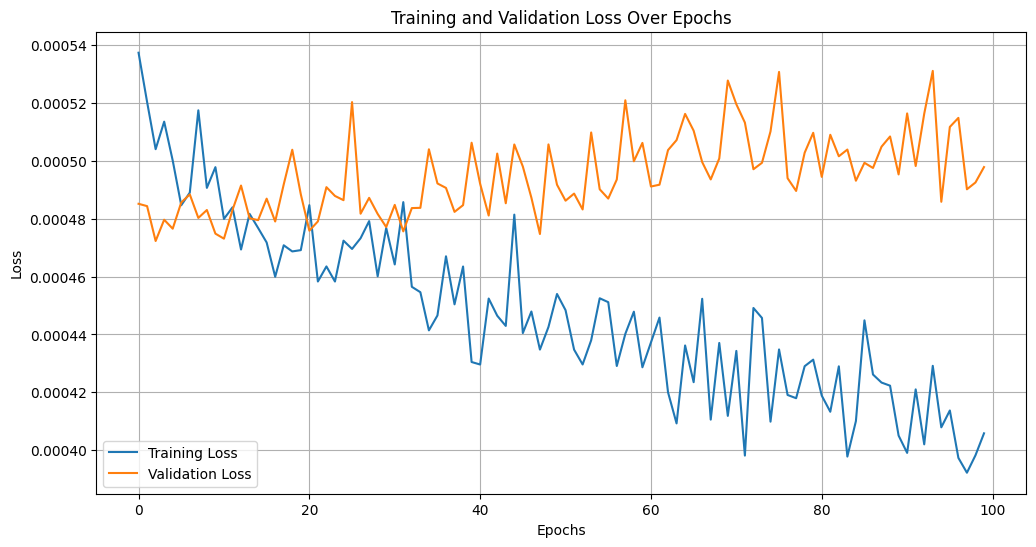

8/8 [==============================] - 0s 572us/step


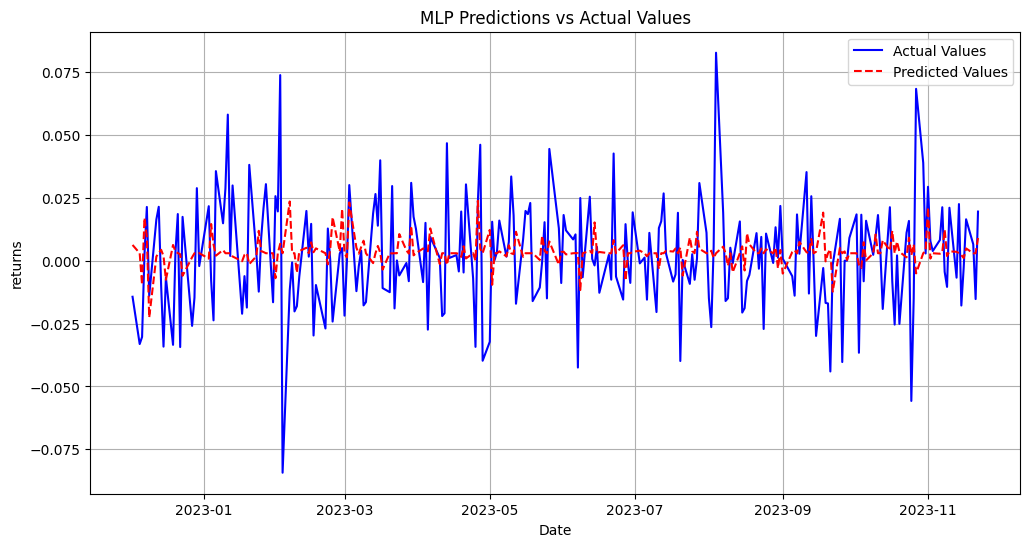

In [21]:
mlp_returns = TimeSeriesModel(df["returns"], specific_lags, random_state=42)
mlp_returns.create_lagged_dataset()
mlp_returns.split_data()
mlp_returns.standardize_data()

# Performing hyperparameter tuning
mlp_returns.hyperparameter_tuning(directory="MLP", project_name="MLP_Returns")

# Training the model with the best hyperparameters
history = mlp_returns.best_model.fit(mlp_returns.X_train, mlp_returns.y_train, epochs=100, batch_size=32,
                                   validation_data=(mlp_returns.X_test, mlp_returns.y_test))

# Plotting the training and validation loss
mlp_returns.plot_loss(history)

# Make predictions on the test data
y_pred = mlp_returns.best_model.predict(mlp_returns.X_test)

# Plotting the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(mlp_returns.y_test.index, mlp_returns.y_test, label='Actual Values', color='blue')
plt.plot(mlp_returns.y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('returns')
plt.title('MLP Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

### c. Using past information of the fractionally differenced time series as inputs, build and train an MLP that is designed to predict the fractionally-differenced version of the time series.

Reloading Tuner from MLP\mlp_close_fd\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                480       
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                3104      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
_________________________________________________________________
Epoc

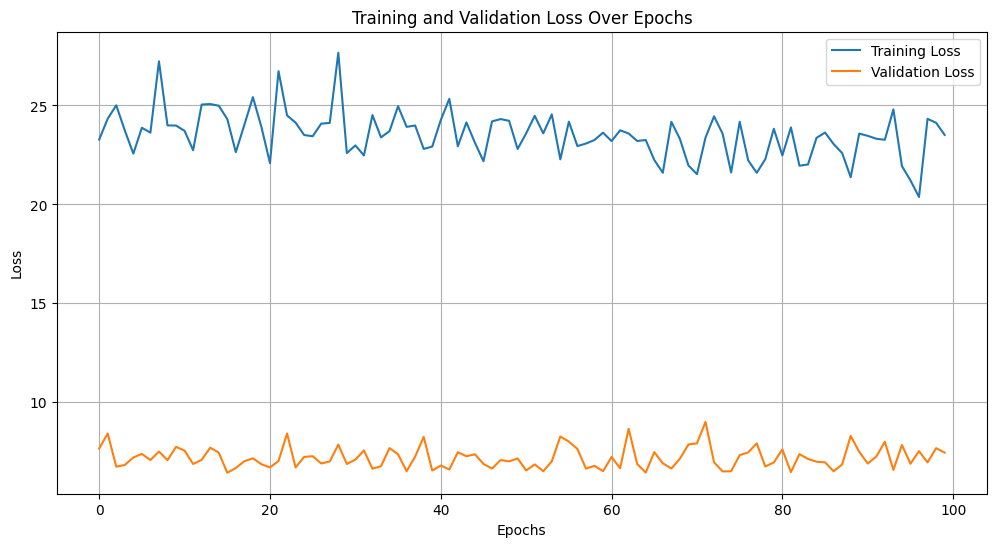

8/8 [==============================] - 0s 429us/step


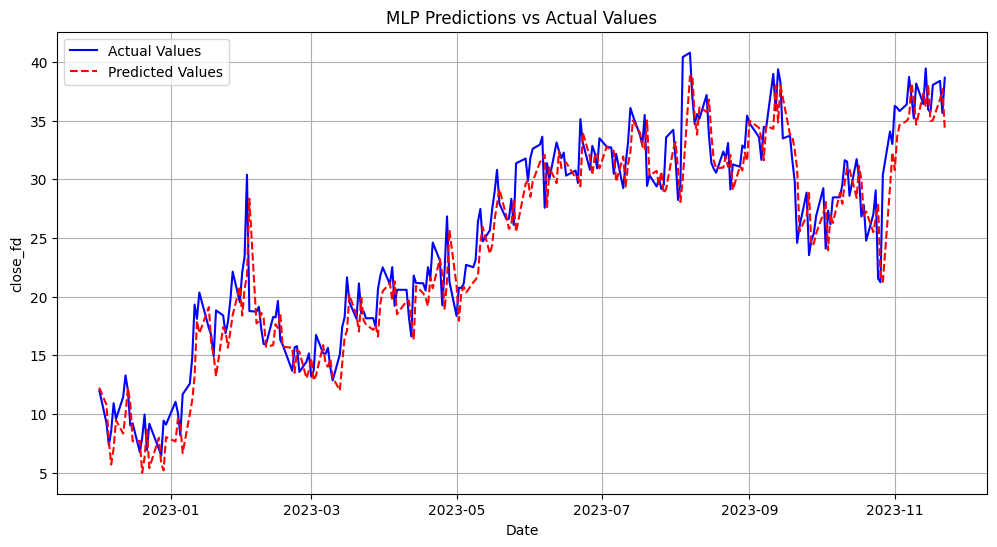

In [22]:
mlp_close_fd = TimeSeriesModel(df["close_fd"], specific_lags, random_state=42)
mlp_close_fd.create_lagged_dataset()
mlp_close_fd.split_data()
mlp_close_fd.standardize_data()

# Performing hyperparameter tuning
mlp_close_fd.hyperparameter_tuning(directory="MLP", project_name="mlp_close_fd")

# Training the model with the best hyperparameters
history = mlp_close_fd.best_model.fit(mlp_close_fd.X_train, mlp_close_fd.y_train, epochs=100, batch_size=32,
                                   validation_data=(mlp_close_fd.X_test, mlp_close_fd.y_test))

# Plotting the training and validation loss
mlp_close_fd.plot_loss(history)

# Make predictions on the test data
y_pred = mlp_close_fd.best_model.predict(mlp_close_fd.X_test)

# Plotting the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(mlp_close_fd.y_test.index, mlp_close_fd.y_test, label='Actual Values', color='blue')
plt.plot(mlp_close_fd.y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('close_fd')
plt.title('MLP Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

### d. Summary

**a.**	Model predictions consistently underestimate the actual values during the whole test sample. Moreover, they are also quite volatile as they show a little erratic behaviour compared with original prices. This chart may indicate that the model suffers from underfitting since both the training and validation loss are large. The model is unable to grasp the patterns and generalize from the data. Hence, to address that we may need to increase the complexity of the model (e.g. by adding more layers), improve the hyperparameters tuning and reevaluating the data preprocessing steps to address underfitting issues.

**b.**	With this model, we see a huge decrease in the loss as compared to the former. however, as the training loss decreases, the validation loss also increases (evident in the graph). This is a classic indication of overfitting. It suggests that the model is learning too much from the specific details and noise in the training data, to the extent that it negatively impacts its ability to generalize to new, unseen data. To address the issue, we may want to reduce the complexity of the model, regularize the model by applying techniques like L1/L2 regularization or dropout, hyperparameter tuning, and increase data size.

**c.**	The model summary indicates a total of 3,617 parameters that are trainable. The model starts with relatively high losses (around 23 on training and 7 on validation). Throughout training, while there are fluctuations, both training and validation losses remain relatively high. The validation loss doesn't improve significantly over epochs, remaining in the range of 6-9. The training loss seems to remain consistently high (around 20-26), indicating that the model is struggling to minimize errors even on the training data. The model might be too complex or not learning well from the provided data. The dropout layers might not be effectively reducing overfitting. To address this, we should adjust hyperparameters to improve its ability to learn patterns and experiment with different architectures, activation functions, or regularization techniques.

# Step 3

### a. Using the GAF representation of the time series, build and train a CNN that is designed to predict the level of the time series.

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pyts.image import GramianAngularField
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters
import matplotlib.pyplot as plt


class TimeSeriesCNNModel:
    def __init__(self, series, window_size, random_state=None):
        """
        Initializes the TimeSeriesCNNModel.

        :param series: pd.Series, the time series data
        :param window_size: int, size of the window for creating slices
        :param random_state: int or None, seed for random state
        """
        self.series = series
        self.window_size = window_size
        self.random_state = random_state
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.history = None

    def create_slices(self):
        """
        Creates slices of the time series data.

        :return: np.array, slices of the time series data
        """
        slices = []
        for i in range(self.window_size, len(self.series)):
            slices.append(self.series.iloc[i - self.window_size:i])
        return np.array(slices)

    def transform_and_split_data(self, transformer):
        """
        Transforms the slices using a given transformer and splits the data into training and testing sets.

        :param transformer: Transformer for transforming slices (e.g., GramianAngularField)
        """
        slices = self.create_slices()
        X = ((transformer.transform(slices) + 1) / 2) * 255
        y = self.series[self.window_size:]

        # Splitting the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, shuffle=False, random_state=self.random_state
        )
        
    def hyperparameter_tuning(self, directory, project_name, max_epochs=30, factor=3):
        """
        Perform hyperparameter tuning using Keras Tuner.

        :param max_epochs: int, the maximum number of epochs per trial
        :param factor: int, reduction factor for the number of trials
        :param directory: str, directory to store tuning results
        :param project_name: str, project name for tuning
        """
        tuner = Hyperband(
            self.build_model,
            objective='val_loss',
            max_epochs=max_epochs,
            factor=factor,
            directory=directory,
            project_name=project_name
        )

        tuner.search(self.X_train, self.y_train, validation_data=(self.X_test, self.y_test), epochs=max_epochs,
                     batch_size=32, verbose=0)

        # Getting the best model and hyperparameters
        self.best_model = tuner.get_best_models(num_models=1)[0]
        best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

        # Displaying the summary of the best model
        self.best_model.summary()

        # Retraining the best model
        self.best_model.fit(self.X_train, self.y_train, epochs=100, batch_size=32,
                            validation_data=(self.X_test, self.y_test), verbose=0)

    def build_model(self, hp):
        """
        Builds a CNN model for time series prediction.

        :param hp: HyperParameters object
        :return: Keras model
        """
        model = Sequential()
        model.add(InputLayer(input_shape=(self.window_size, self.window_size, 1)))

        for i in range(hp.Int('num_conv_layers', 1, 3)):
            model.add(Conv2D(hp.Int(f'conv_units_{i}', min_value=8, max_value=64, step=8),
                             3, activation="relu"))
            model.add(MaxPool2D(2))

        model.add(Flatten())

        for i in range(hp.Int('num_dense_layers', 1, 3)):
            model.add(Dense(hp.Int(f'dense_units_{i}', min_value=16, max_value=128, step=16), activation="relu"))

        model.add(Dense(1))
        model.compile(optimizer=RMSprop(), loss="mean_squared_error")
        return model

    def plot_loss(self, history):
        """
        Plots the training and validation loss over epochs.
        """
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(12, 6))
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def print_model_summary(self):
        """
        Prints the summary of the trained model.
        """
        self.model.summary()

    def plot_actual_vs_predicted(self):
        """
        Plots the actual vs predicted values on the test set.
        """
        y_pred = self.model.predict(self.X_test)

        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test.index, self.y_test, label='Actual Values', color='blue')
        plt.plot(self.y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('BTC Price')
        plt.title('CNN Actual vs Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

Reloading Tuner from CNN\cnn_close\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 40)        400       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 40)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 14440)             0         
                                                                 
 dense (Dense)               (None, 112)               1617392   
                                                                 
 dense_1 (Dense)             (None, 1)                 113       
                                                                 
Total params: 1,617,905
Trainable params: 1,617,905
Non-trainable params: 0

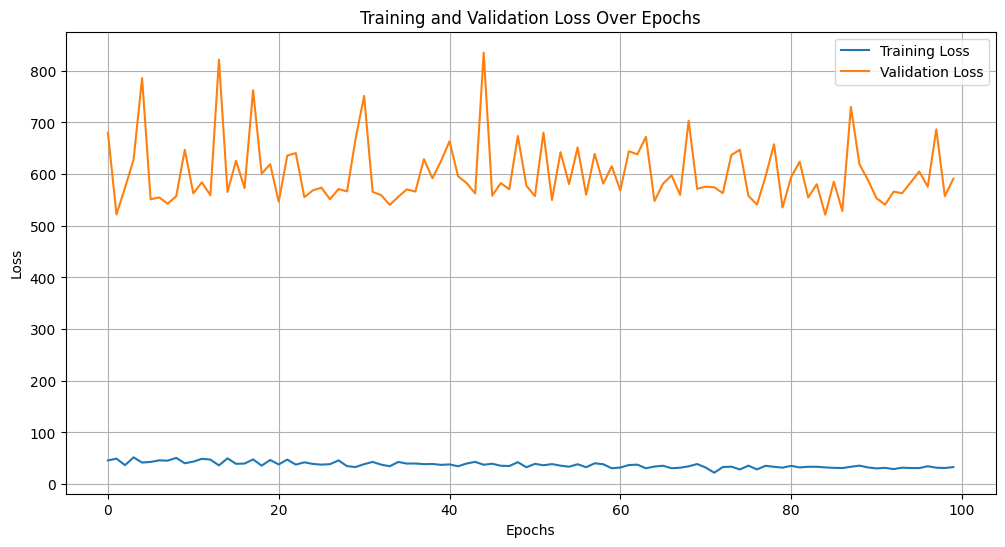

8/8 [==============================] - 0s 2ms/step


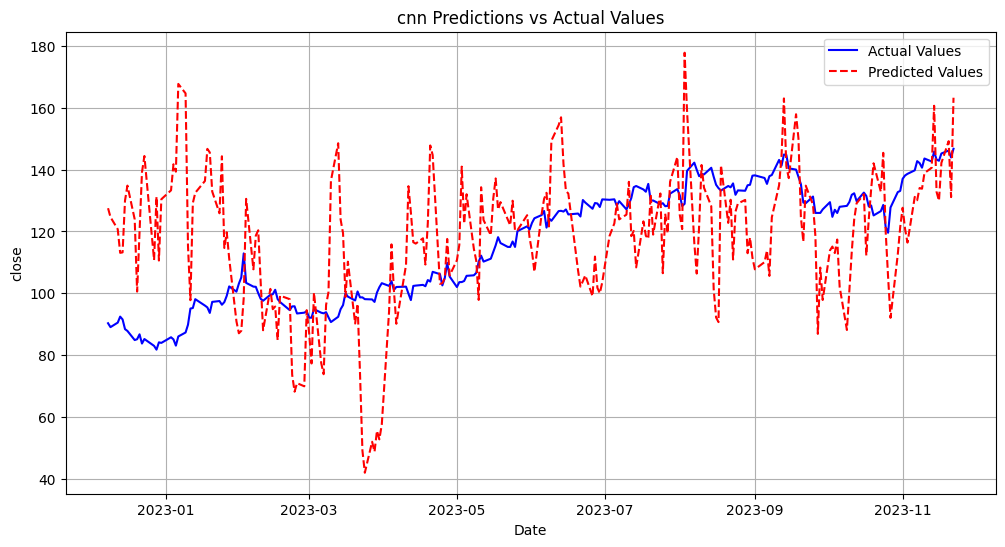

In [24]:
window_size = 40

cnn_close = TimeSeriesCNNModel(df["close"], window_size, random_state=42)
cnn_close.create_slices()

transformer = GramianAngularField()
cnn_close.transform_and_split_data(transformer)

# Performing hyperparameter tuning
cnn_close.hyperparameter_tuning(directory="CNN", project_name="cnn_close")

# Training the model with the best hyperparameters
history = cnn_close.best_model.fit(cnn_close.X_train, cnn_close.y_train, epochs=100, batch_size=32,
                                   validation_data=(cnn_close.X_test, cnn_close.y_test))

# Plotting the training and validation loss
cnn_close.plot_loss(history)

# Make predictions on the test data
y_pred = cnn_close.best_model.predict(cnn_close.X_test)

# Plotting the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(cnn_close.y_test.index, cnn_close.y_test, label='Actual Values', color='blue')
plt.plot(cnn_close.y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('close')
plt.title('cnn Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

### b. Using the GAF representation of the stationary time series, build and train a CNN that is designed to predict the stationary version of the time series.

Reloading Tuner from CNN\cnn_returns\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 56)        560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 56)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 16)        8080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense 

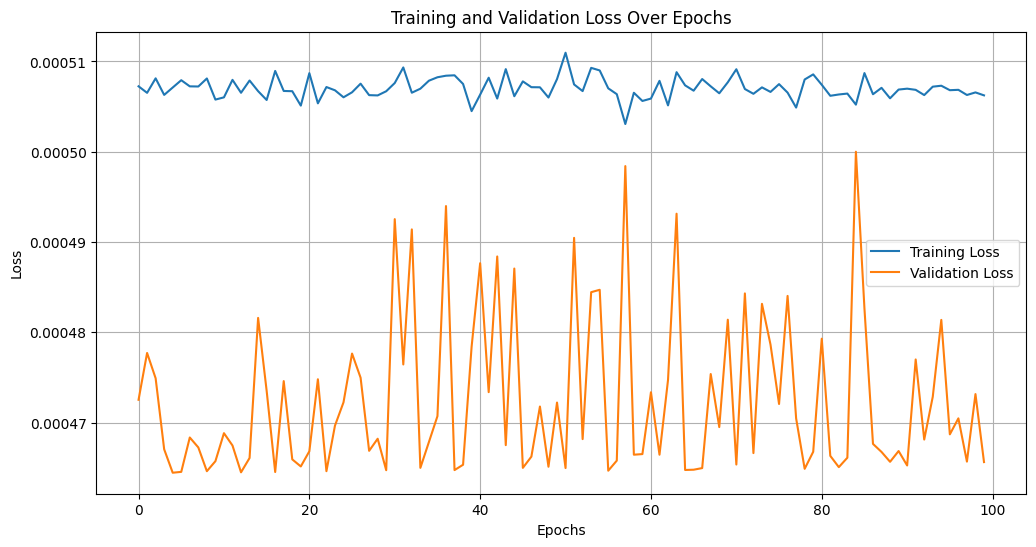

8/8 [==============================] - 0s 4ms/step


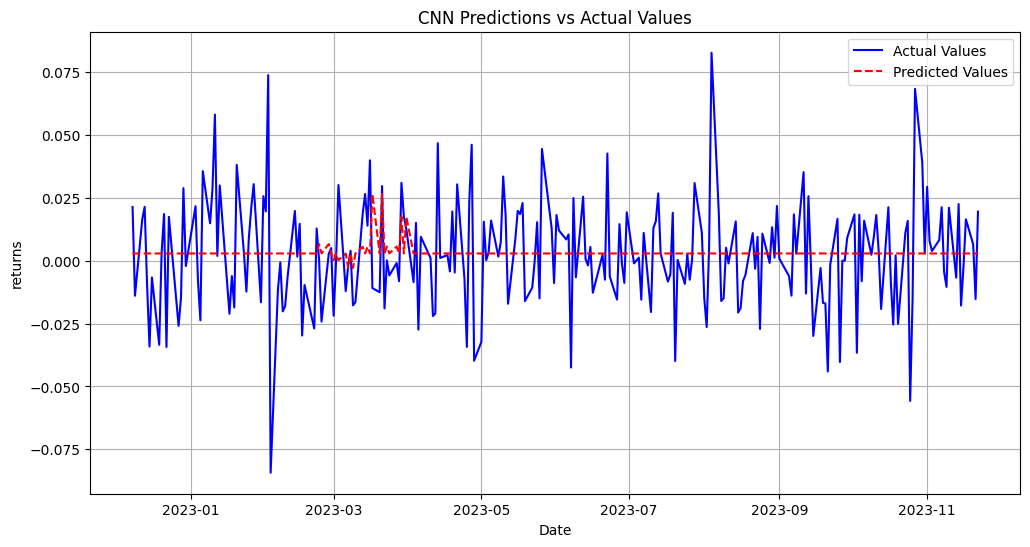

In [25]:
window_size = 40

cnn_returns = TimeSeriesCNNModel(df["returns"], window_size, random_state=42)
cnn_returns.create_slices()

transformer = GramianAngularField()
cnn_returns.transform_and_split_data(transformer)

# Performing hyperparameter tuning
cnn_returns.hyperparameter_tuning(directory="CNN", project_name="cnn_returns")

# Training the model with the best hyperparameters
history = cnn_returns.best_model.fit(cnn_returns.X_train, cnn_returns.y_train, epochs=100, batch_size=32,
                                   validation_data=(cnn_returns.X_test, cnn_returns.y_test))

# Plotting the training and validation loss
cnn_returns.plot_loss(history)

# Make predictions on the test data
y_pred = cnn_returns.best_model.predict(cnn_returns.X_test)

# Plotting the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(cnn_returns.y_test.index, cnn_returns.y_test, label='Actual Values', color='blue')
plt.plot(cnn_returns.y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('returns')
plt.title('CNN Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

### c. Using the GAF representation of the fractionally-differenced time series, build and train a CNN that is designed to predict the fractionally differenced version of the time series.

Reloading Tuner from CNN\cnn_close_fd\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 56)        560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 56)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 20216)             0         
                                                                 
 dense (Dense)               (None, 96)                1940832   
                                                                 
 dense_1 (Dense)             (None, 64)                6208      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
      

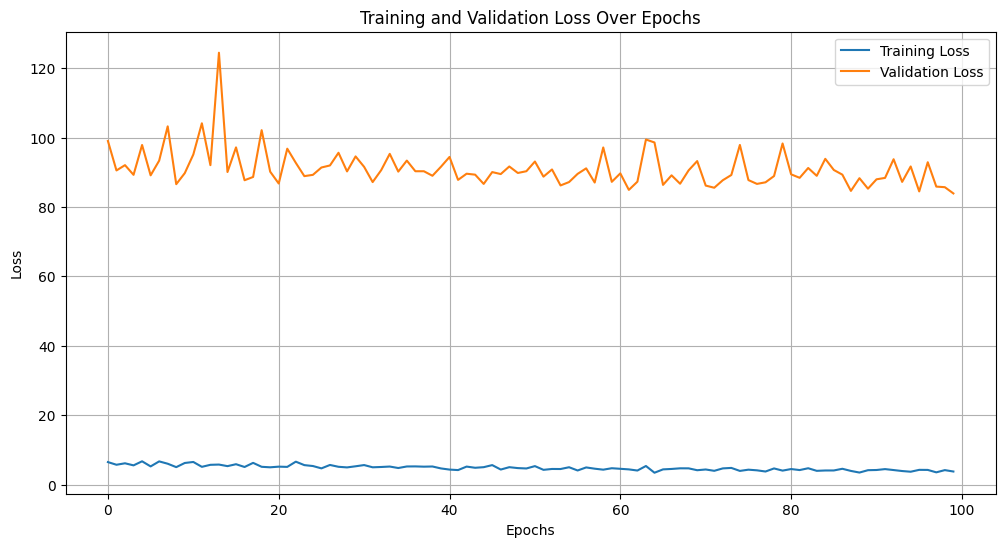

8/8 [==============================] - 0s 4ms/step


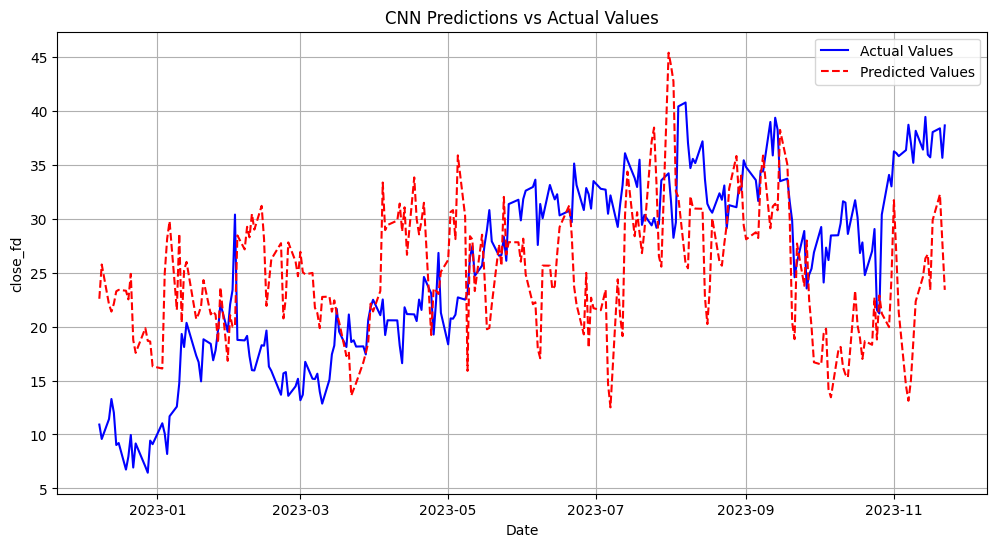

In [26]:
window_size = 40

cnn_close_fd = TimeSeriesCNNModel(df["close_fd"], window_size, random_state=42)
cnn_close_fd.create_slices()

transformer = GramianAngularField()
cnn_close_fd.transform_and_split_data(transformer)

# Performing hyperparameter tuning
cnn_close_fd.hyperparameter_tuning(directory="CNN", project_name="cnn_close_fd")

# Training the model with the best hyperparameters
history = cnn_close_fd.best_model.fit(cnn_close_fd.X_train, cnn_close_fd.y_train, epochs=100, batch_size=32,
                                   validation_data=(cnn_close_fd.X_test, cnn_close_fd.y_test))

# Plotting the training and validation loss
cnn_close_fd.plot_loss(history)

# Make predictions on the test data
y_pred = cnn_close_fd.best_model.predict(cnn_close_fd.X_test)

# Plotting the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(cnn_close_fd.y_test.index, cnn_close_fd.y_test, label='Actual Values', color='blue')
plt.plot(cnn_close_fd.y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('close_fd')
plt.title('CNN Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

#### d. Summary

**a.**	The number of adjustable parameters: conv2d layer has 400 trainable parameters, while the dense and dense_1 layer have 1,617,392 and 113 trainable parameters respectively. The networks final output consists of 112 neuron dense layers and 1 neuron dense_1 layer. The validation loss values range from approximately 579 to 875 across different epochs, indicating the deviation between predicted and actual closing prices on the validation set. 
The model might have difficulties in accurately predicting the closing prices of AMZN stock based on the high validation loss values, suggesting that the model might not be suitable for forecasting AMZN stock prices using this architecture.

**b.**	The loss values for both training and validation are relatively close throughout the epochs, indicating that the model isn't overfitting or underfitting significantly. However, the loss values themselves are relatively high, suggesting that the model might not be learning the patterns effectively.

**c.**	The model has a total of 1,956,049 parameters. The average loss on a separate validation dataset for each epoch. It starts around 88 and goes up to 130, showing higher values than the training loss. We have one convolutional layer that outputs feature maps with dimensions 38x38 and 56 channels. The loss seems to be relatively high for both training and validation sets. If the validation loss is consistently much higher than the training loss, it could suggest the model is overfitting, meaning it's learning to memorize the training data but doesn't generalize well to new data. The graph also shows the training loss function is stagnant over epochs suggesting the need for model adjustments or regularization techniques to prevent overfitting.


# Step 4

**a.**	The MLP seems simplistic, failing to capture the patterns in the data, as evidenced by consistently large losses, hence underfitting. The CNN’s validation loss also fluctuates significantly hence the model struggles to predict closing prices accurately.

**b.**	The MLP model performs significantly better but starts to overfit as the training loss decreases while the validation loss increases, indicating it's learning from noise. The CNN model’s huge and close loss values suggest ineffective pattern learning.

**c.**	For the fractional differencing, The MLP model struggle to learn from the data effectively whiles the CNN show signs of stagnancy in improvement.

In summary, while both MLPs and CNNs have their strengths in capturing different types of features in various data domains, their application in time series analysis, especially stock price forecasting, requires careful consideration of temporal hierarchies, relevant feature extraction, and avoiding over-reliance on complex architectures that might hinder interpretability and efficient parameter utilization.

In both steps, the models face challenges like overfitting, underfitting, or ineffective learning due to architectural complexities or dataset limitations. These models might not effectively extract relevant features from both local and global perspectives.

Adjusting model complexity, regularization techniques, hyperparameter tuning, or dataset augmentation could help improve the models' performance.
